In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

In [6]:
!pip install pymc3

fastai 1.0.55 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [34]:
def tau(A, rc, x, y):
    
    r = np.sqrt((xx - x)**2 + (yy - y)**2)
    
    return A * (1 + (r/rc)**2)**(-1)

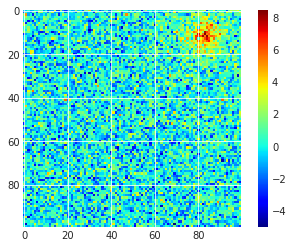

In [91]:
A = 7
Rc = 4.8
X, Y = 12, 83
xx, yy = np.indices((100, 100))

c1 = tau(A, Rc, X, Y)
c2 = tau(4, 2.2, 40, 30)

nse = np.random.normal(0, 1.5, (100, 100))        #np.random.normal(0, 6e-6, (100, 100))

data_ = c1 + nse

plt.imshow(data_, cmap = 'jet')
plt.colorbar();

In [92]:
COV_ = np.cov(data_)

In [93]:
with pm.Model() as model:
    
    # Priors
    #RC_ = pm.Uniform('rc', lower = 0.25, upper = 20)
    #AA  = pm.Uniform('AA', lower = 0.1, upper = 10)
    XX  = pm.Uniform('Xc', lower = 10, upper = 195)
    YY  = pm.Uniform('Yc', lower = 10, upper = 195)
    AA = pm.Uniform('A', lower = 0, upper = 11)
    RC = pm.Uniform('Rc', lower = 0, upper = 10)
    
    rr = np.sqrt((xx - XX)**2 + (yy - YY)**2)
    # Auxiliary variable
    y_est = AA * (1 + (rr/RC)**2)**(-1)
    
    #sigma = pm.Uniform('sig', lower = 0, upper = 3, shape = (40, 40))
    
    # Likelihood
    likelihood = pm.MvNormal('y', mu = y_est, cov = COV_**2, observed = data_)
    
    # Inference
    start = pm.find_MAP()
    step = pm.SMC()        # Hamiltonian MCMC with No U-Turn Sampler
    trace = pm.sample(5000, step, start, progressbar = True, chains = 10)
    burned_trace = trace[2000:]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -19,998, ||grad|| = 165.26: 100%|██████████| 51/51 [00:00<00:00, 688.12it/s]  
Sample initial stage: ...
Stage: 0 Beta: 0.016 Steps: 25
Stage: 1 Beta: 0.026 Steps: 13
Stage: 2 Beta: 0.034 Steps: 4
Stage: 3 Beta: 0.048 Steps: 16
Stage: 4 Beta: 0.101 Steps: 4
Stage: 5 Beta: 0.211 Steps: 8
Stage: 6 Beta: 0.446 Steps: 4
Stage: 7 Beta: 0.945 Steps: 6
Stage: 8 Beta: 1.000 Steps: 4


In [94]:
for param, gt in zip(['Xc', 'Yc', 'A', 'Rc'], [X, Y, A, Rc]):
    
    print(param, '--', np.round(burned_trace[param].mean(), 2), '--', gt, '\n')

Xc -- 11.93 -- 12 

Yc -- 83.11 -- 83 

A -- 6.49 -- 7 

Rc -- 5.2 -- 4.8 



(array([  8.,  73., 220., 541., 849., 757., 379., 140.,  24.,   9.]),
 array([10.63745625, 10.90663681, 11.17581737, 11.44499793, 11.71417849,
        11.98335905, 12.25253961, 12.52172017, 12.79090073, 13.06008129,
        13.32926185]),
 <a list of 10 Patch objects>)

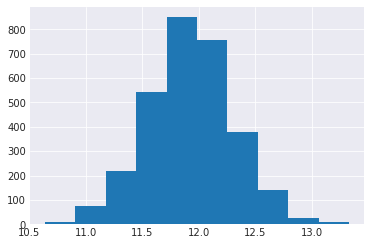

In [95]:
plt.hist(burned_trace['Xc'])

In [96]:
cluster1 = [burned_trace[param].mean() for param in ['A', 'Rc', 'Xc', 'Yc']]

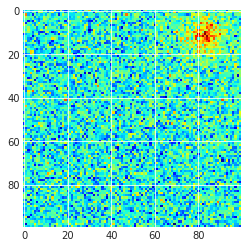

In [97]:
plt.imshow(tau(*cluster1) + nse, cmap = 'jet');